In [26]:
%pip install -U textblob
!python -m textblob.download_corpora

%pip install nltk

%pip install --upgrade gensim

#%pip install -U scikit-learn

Note: you may need to restart the kernel to use updated packages.
[nltk_data] Downloading package brown to
[nltk_data]     /Users/yohanismael/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/yohanismael/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/yohanismael/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/yohanismael/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package conll2000 to
[nltk_data]     /Users/yohanismael/nltk_data...
[nltk_data]   Package conll2000 is already up-to-date!
[nltk_data] Downloading package movie_reviews to
[nltk_data]     /Users/yohanismael/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
Finis

In [27]:
import nltk

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from textblob import TextBlob
from datetime import datetime

import gensim
from gensim.models import Word2Vec

from datetime import datetime

In [28]:
def str_to_timestamp(s):
    out=[]

    s2=str.split(s,'+')
    s3=str.split(s2[0],' ')

    s4=str.split(s3[0],'-')

    s5=str.split(s3[1],':')
    year=int(s4[0])
    month=int(s4[1])
    day=int(s4[2])
    hour=int(s5[0])
    minute=int(s5[1])
    second=int(s5[2])

    return(datetime(year=year,month=month,day=day,hour=hour,minute=minute,second=second).timestamp())

from nltk.tokenize import word_tokenize

def NumStr(mot):
    res = ''.join(filter(lambda i: i.isdigit(), mot))
    if (res==''):
        return False
    return True


def extract_keywords(text):
    # Tokenize the text
    tokens = word_tokenize(text)

    # Apply part-of-speech tagging
    tagged_tokens = nltk.pos_tag(tokens)

    # Select only nouns and adjectives
    keywords = [word for word, pos in tagged_tokens if (pos in ['NN', 'NNS', 'NNP', 'NNPS', 'JJ', 'JJR', 'JJS'] and not NumStr(word))]

    return keywords

def extract_sentiment_polarity(text):
    blob=TextBlob(text)
    return(blob.sentiment.polarity)

In [29]:
data=pd.read_csv('data/minnesota.csv')
df=data
print('start')

df['keywords'] = df['tweet_text'].apply(extract_keywords)

print('end of keywords')

df['sentiment_polarity']=df['tweet_text'].apply(extract_sentiment_polarity)

print('end of polarity')

df['timestamps']=df['tweet_created_dt'].apply(str_to_timestamp)
df['timestamps']=df['timestamps']-df['timestamps'].min()

print('end of timestamps')

clean_data=df
clean_data.to_csv("data/clean_data.csv")

start
end of keywords
end of polarity
end of timestamps


# general Word2Vec

In [30]:
model = Word2Vec(sentences=data['keywords'], vector_size=100, window=5, min_count=2, workers=4)
model.save("Word2vec_models/word2vec.model")
word_vectors = model.wv
del model

def word2vectors(l):
    try:
        x = word_vectors[l]
    except KeyError:
        return 
    return x
    

def list2vectors(L):
    out=[]
    for i in L:
        out.append(word2vectors(i))
    return(np.asarray(out,dtype=object))

In [31]:
clean_data['vectors']=clean_data['keywords'].apply(list2vectors)

In [32]:
L=[]
for keywords in clean_data[clean_data['sentiment_polarity']<0]['keywords']:
    for words in keywords:
        L.append(words)
len(L)
word_hist=pd.value_counts(np.array(L))
word_hist[0:100]

black               73107
matter              45865
lives               36172
i                   30541
blacklivesmatter    28183
                    ...  
others               1189
system               1188
sick                 1182
words                1174
state                1169
Length: 100, dtype: int64

In [33]:
L=[]
for keywords in clean_data['keywords']:
    for words in keywords:
        L.append(words)
print(len(L))
word_hist=pd.value_counts(np.array(L))
print(word_hist[0:100]/len(word_hist))
print(len(word_hist))

3082798
blacklivesmatter    0.952082
black               0.761230
i                   0.570899
matter              0.472942
floyd               0.421526
                      ...   
matters             0.023057
words               0.022826
riots               0.022746
let                 0.022702
color               0.022637
Length: 100, dtype: float64
138091


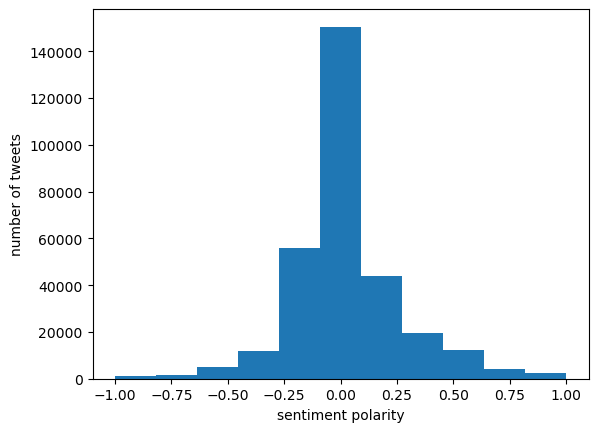

0.0234950563672169

In [34]:
plt.hist(clean_data['sentiment_polarity'],bins=11)
plt.xlabel('sentiment polarity')
plt.ylabel('number of tweets')
plt.savefig("figures_out/fig_sentiment_pol.png",transparent=True)
plt.show()
clean_data['sentiment_polarity'].mean()

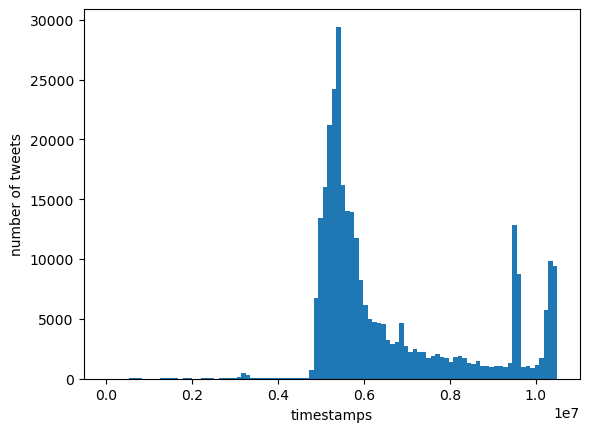

In [35]:
plt.hist(clean_data['timestamps'],bins=100)
plt.xlabel('timestamps')
plt.ylabel('number of tweets')
plt.savefig("figures_out/fig_timestamps.png",transparent=True)
plt.show()

In [36]:
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

4856398.67768595

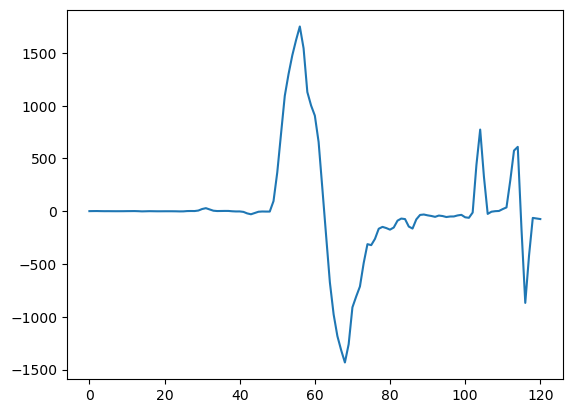

In [37]:
time_day=60*60*24
nb_bins=int(clean_data['timestamps'].max()/time_day)
coef_smooth=int(nb_bins/10)

hist,e=np.histogram(clean_data['timestamps'],nb_bins)
smooth_hist=smooth(hist,coef_smooth)
x_hist=range(nb_bins)
dhist=np.gradient(smooth_hist,x_hist)
plt.plot(x_hist,dhist)
the_time=e[dhist.argmax()]
before_the_time=the_time-time_day
the_time

In [38]:
before=clean_data[clean_data['timestamps']<the_time]
before['sentiment_polarity'].mean()

-0.0336750017316793

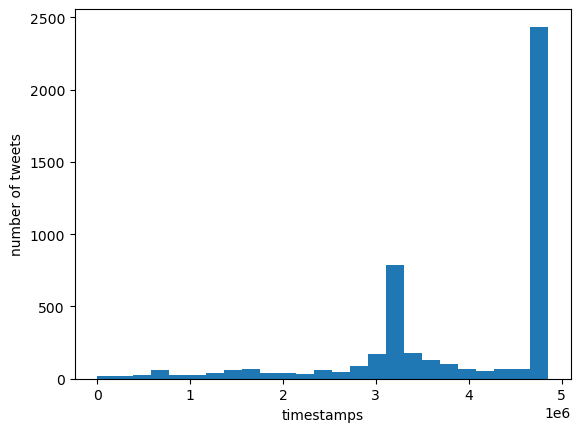

In [39]:
plt.hist(before['timestamps'],bins='auto')
plt.xlabel('timestamps')
plt.ylabel('number of tweets')
plt.savefig("figures_out/fig_timestamps_before.png",transparent=True)
plt.show()

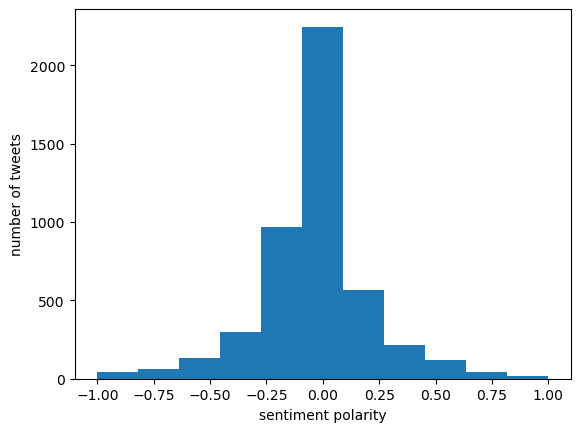

-0.0336750017316793

In [40]:
plt.hist(before['sentiment_polarity'],bins=11)
plt.xlabel('sentiment polarity')
plt.ylabel('number of tweets')
plt.savefig("figures_out/fig_sentiment_pol_before.png",transparent=True)
plt.show()
before['sentiment_polarity'].mean()

In [41]:
L=[]
for keywords in before['keywords']:
    for words in keywords:
        L.append(words)
len(L)
word_hist=pd.value_counts(np.array(L))
word_hist[0:50]

blacklivesmatter          1924
black                     1782
i                         1484
georgefloyd                963
matter                     759
george                     717
floyd                      712
lives                      683
people                     664
police                     538
white                      434
man                        405
blacklivesmatters          351
justice                    318
icantbreathe               303
murder                     300
confusion                  250
video                      247
minneapolis                237
life                       227
death                      208
today                      201
officers                   199
cops                       196
justiceforgeorgefloyd      190
racism                     168
america                    166
nan                        161
name                       160
irunwithmaud               159
men                        155
time                       154
justicef

## Spliting data -> we will try to train a simple model

X = every info we have about tweets of several periods

y = number of tweets on the period after after

In [42]:
def time_separation(df,t_out=time_day,n_in=5):
    X_out=[]
    y_out=[]
    dt=t_out*n_in

    for time in range(0,int(df['timestamps'].max()),t_out):
        o=df[df.timestamps<time+dt]
        X_out.append(o[o.timestamps>time])
        X_out[-1]=X_out[-1].drop(columns='timestamps')

        print("%.3f" % (time/int(df['timestamps'].max())), end="\r")
    print("X finish")

    t=0
    for time in range(0,int(df['timestamps'].max()),t_out):
        y_out.append(df[df['timestamps']>t].count()[0]-df[df['timestamps']>time].count()[0])
        t=time

        print("%.3f" % (time/int(df['timestamps'].max())), end="\r")
    print('y finish')


    return np.asarray(X_out[:len(X_out)-n_in], dtype=object),np.asarray(y_out[n_in:], dtype=int)

In [43]:
train_split=clean_data.sample(frac=.8)
test_split=clean_data.drop(train_split.index)

train_split_calc = train_split[['retweets','favorites','sentiment_polarity','vectors','timestamps']]
test_split_calc = test_split[['retweets','favorites','sentiment_polarity','vectors','timestamps']]

In [44]:
mult=1
div=24
nb=5*24

X_train,y_train=time_separation(train_split_calc,mult*time_day//div,nb)
print('train finish')
X_test,y_test=time_separation(test_split_calc,mult*time_day//div,nb)
print('test finish')

X finish
y finish
train finish
X finish
y finish
test finish


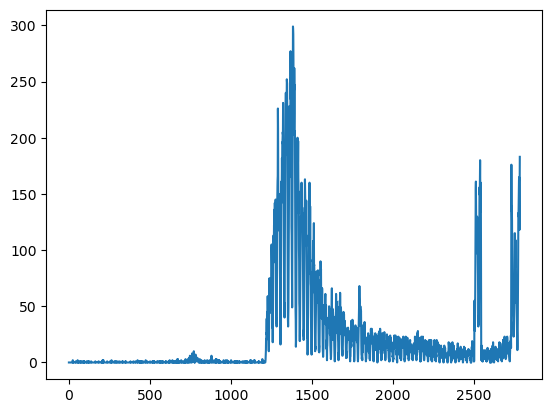

In [45]:
plt.plot(range(len(y_test)),y_test)
plt.show()

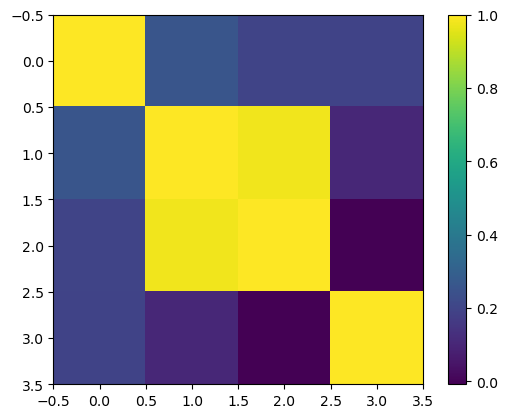

In [46]:
sent_plot=[]
fav_plot=[]
retweets_plot=[]
for i in range(len(X_train)):
    sent_plot.append(X_train[i]['sentiment_polarity'].mean())
    fav_plot.append(X_train[i]['favorites'].mean())
    retweets_plot.append(X_train[i]['retweets'].mean())
    
datfram=pd.DataFrame((sent_plot,fav_plot,retweets_plot,y_train),index=["sent","fav","rt","y"]).transpose()
plt.imshow(datfram.corr())
plt.colorbar()
plt.show()

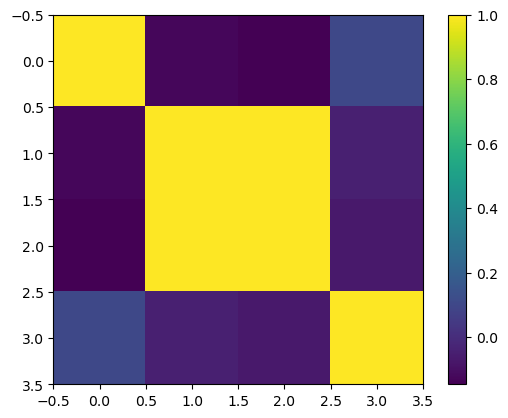

In [47]:
sent_plot=[]
fav_plot=[]
retweets_plot=[]
for i in range(len(X_test)):
    sent_plot.append(X_test[i]['sentiment_polarity'].mean())
    fav_plot.append(X_test[i]['favorites'].mean())
    retweets_plot.append(X_test[i]['retweets'].mean())
    
datfram=pd.DataFrame((sent_plot,fav_plot,retweets_plot,y_test),index=["sent","fav","rt","y"]).transpose()
plt.imshow(datfram.corr())
plt.colorbar()
plt.show()

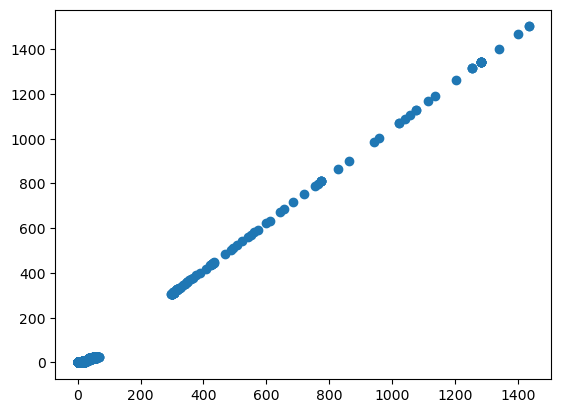

In [48]:
plt.scatter(fav_plot,retweets_plot)

# Clustering Method

In [2]:
%pip install pymc3

%pip install sklearn

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [4]:
import nltk

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from textblob import TextBlob
from datetime import datetime

import gensim
from gensim.models import Word2Vec

from datetime import datetime

In [5]:
def str_to_timestamp(s):
    out=[]

    s2=str.split(s,'+')
    s3=str.split(s2[0],' ')

    s4=str.split(s3[0],'-')

    s5=str.split(s3[1],':')
    year=int(s4[0])
    month=int(s4[1])
    day=int(s4[2])
    hour=int(s5[0])
    minute=int(s5[1])
    second=int(s5[2])

    return(datetime(year=year,month=month,day=day,hour=hour,minute=minute,second=second).timestamp())

from nltk.tokenize import word_tokenize

def NumStr(mot):
    res = ''.join(filter(lambda i: i.isdigit(), mot))
    if (res==''):
        return False
    return True


def extract_keywords(text):
    # Tokenize the text
    tokens = word_tokenize(text)

    # Apply part-of-speech tagging
    tagged_tokens = nltk.pos_tag(tokens)

    # Select only nouns and adjectives
    keywords = [word for word, pos in tagged_tokens if (pos in ['NN', 'NNS', 'NNP', 'NNPS', 'JJ', 'JJR', 'JJS'] and not NumStr(word))]

    return keywords

In [6]:
clean_data=pd.read_csv("data/clean_data.csv")

In [7]:
def sliding_window(df,size,sliding):
    X_out=[]

    for time in range(0,int(df['timestamps'].max()),sliding):
        o=df[df.timestamps<time+size]
        X_out.append(o[o.timestamps>time])

        print("%.3f" % (time/int(df['timestamps'].max())), end="\r")
    print("finish")
    return X_out

def dfToListofVectors(df):
    out=[]
    for l_vect in df.vectors:
        for v in l_vect:
            
            out.append(v)
            
    return out

In [8]:
time_day=60*60*24
L=sliding_window(clean_data,time_day*4,time_day)
first=L[0]

finish


In [9]:
model = Word2Vec(sentences=first['keywords'], vector_size=100, window=0, min_count=0, workers=0)
model.save("Word2vec_models/test_word2vec.model")
word_vectors = model.wv
del model

def word2vectors(l):
    try:
        x = word_vectors[l]
    except KeyError:
        return 
    return x
    

def list2vectors(L):
    out=[]
    for i in L:
        out.append(word2vectors(i))
    return(np.asarray(out,dtype=object))

In [10]:

i=0
for keywords in first.keywords:
    for keyword in keywords:
        i+=1

arr=np.ndarray((i,100))
i=0
for keywords in first.keywords:
    for keyword in keywords:
        arr[i]=word_vectors[keyword]
        i+=1


In [11]:
arr

array([[ 0.00133252,  0.00654086,  0.0099846 , ...,  0.00905999,
        -0.00579077,  0.00368608],
       [-0.00053623,  0.00023643,  0.00510335, ..., -0.00704156,
         0.00090146,  0.00639253],
       [ 0.00816812, -0.00444303,  0.00898543, ..., -0.00453567,
         0.00406171, -0.00427018],
       ...,
       [-0.00957855,  0.00894311,  0.00416507, ...,  0.00711824,
         0.00589144, -0.00558062],
       [-0.00053623,  0.00023643,  0.00510335, ..., -0.00704156,
         0.00090146,  0.00639253],
       [ 0.00257018,  0.00084653, -0.00253944, ..., -0.00166607,
        -0.00945466, -0.00261346]])

## using sklearn

In [68]:
from sklearn.cluster import k_means
X=arr
kmeans=k_means(X,n_clusters=10,n_init='auto')

ModuleNotFoundError: No module named 'sklearn'

In [ ]:
centroids=kmeans[0]

In [ ]:
word_vectors.similar_by_vector(centroids[2])

[('blacklivesmatter', 1.0000001192092896),
 ('gods', 0.21469098329544067),
 ('love', 0.18890605866909027),
 ('day', 0.18855658173561096),
 ('crickets', 0.18359005451202393),
 ('instagood', 0.18345923721790314),
 ('equity', 0.18069222569465637),
 ('bad', 0.17804878950119019),
 ('boys', 0.1716608703136444),
 ('years', 0.1696905791759491)]

## using pymc3

In [12]:
import numpy as np
import pymc3 as pm

def dirichlet_process_event_mixture_model(data, alpha=1.0, n_samples=1000, random_seed=0):
    """Implements a Dirichlet Process Event Mixture Model (DPEMM) for event extraction.

    Args:
    data: numpy array with shape (n_events, n_features)
    alpha: scalar value for the concentration parameter of the Dirichlet process prior
    n_samples: number of samples to draw from the posterior distribution
    random_seed: seed for the random number generator

    Returns:
    trace: a PyMC3 trace object with the posterior samples
    """
    n_events, n_features = data.shape
    with pm.Model() as model:
        # Dirichlet process prior
        theta = pm.Dirichlet("theta", a=np.ones(n_features) * alpha, shape=(1, n_features))

        # Categorical likelihood for each event
        category = pm.Categorical("category", p=theta, shape=n_events)

        # Gaussian likelihood for each feature given the category
        mu = pm.Normal("mu", mu=0, sigma=10, shape=(n_features,))
        sigma = pm.HalfNormal("sigma", sigma=10, shape=(n_features,))
        obs = pm.Normal("obs", mu=mu[category], sigma=sigma[category], observed=data)

    np.random.seed(random_seed)
    with model:
        trace = pm.sample(n_samples, chains=1)

    return trace


In [13]:
def extract_clusters(trace, n_samples=100):
    """Extracts the number of clusters and their centroids from the DPEMM trace.

    Args:
    trace: PyMC3 trace object from the DPEMM model
    n_samples: number of posterior samples to use

    Returns:
    n_clusters: number of clusters
    centroids: numpy array with shape (n_clusters, n_features) with the centroids of each cluster
    """
    n_features = trace["mu"].shape[1]
    categories = trace["category"][-n_samples:]
    n_clusters = len(np.unique(categories))
    centroids = np.zeros((n_clusters, n_features))
    for i in range(n_clusters):
        idx = categories == i
        centroids[i] = np.mean(trace["mu"][-n_samples:][idx], axis=0)

    return n_clusters, centroids


In [14]:
trace=dirichlet_process_event_mixture_model(arr)

ValueError: Input dimension mis-match. (input[0].shape[1] = 100, input[1].shape[1] = 3349)

In [ ]:
arr.shape

(298, 100)